In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import lightgbm as lgb
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
from pathlib import Path
import warnings
import os
import random
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm

import shap

In [ ]:
plt.rcParams['font.family'] = "MS Gothic"
warnings.simplefilter('ignore')

In [ ]:
def fix_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
fix_all_seeds(0)

In [64]:
# Config
SAVE_SUB = True
SAVE_SUB_DIR = Path("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/sub_20230225")
SUB_FILE_NAME = "val2_20230227"

# データ読み込み

In [ ]:
train = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/train.pkl")
test = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/test.pkl")
sub = pd.read_csv("/content/drive/MyDrive/Kaggle/BlueCarbon/raw/submit_example.csv")
train.head(2)

,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,aicial_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,24.989140,125.243164,20.0,20110926,2011.0,9.0,0.050,NaN,0.0,0.000000,...,0.507961,0.287288,-0.278071,-0.808075,-2.341663,2.353039,95.142525,3.728732,-2.405135,3725_10
1,26.996172,127.912025,40.0,2009.7.6-2009.7.28,2009.0,7.0,0.725,NaN,0.0,0.478772,...,0.353645,0.245048,-0.100556,-0.771423,-3.282602,4.672225,174.767501,-0.571513,0.448861,4027_13


In [ ]:
sub.head(2)

,0,0.47
0,1,0.68
1,2,0.25


# 前処理

In [ ]:
# 被度文献データ、海洋環境要因データ、landsat使用
# YMDは使わない
cols_base = train.columns.to_list()[:25]
cols_sentinel = train.columns.to_list()[88:313]
# cols_sentinel = [col for col in cols_sentinel if "MED" in col]
cols_use = cols_base + cols_sentinel

cols_remove = ["YMD"]
cols_use = [col for col in cols_use if not col in cols_remove]
cols_use

['lat',
 'lon',
 'area',
 'year',
 'month',
 'cover',
 'depth_original',
 'cliff_length',
 'aicial_length',
 'beach_length',
 'coast_length',
 'coastal_dist',
 'cold_sst',
 'depth',
 'fetch',
 'hist_cold_sst',
 'hist_warm_sst',
 'river_area',
 'river_dist',
 'Salinity_annual',
 'warm_sst',
 'sst_annual',
 'sst_ymd',
 'sst_diff',
 'MAX_AFRI1600',
 'MAX_AOT',
 'MAX_ARI',
 'MAX_ARVI',
 'MAX_AVI',
 'MAX_B02',
 'MAX_B03',
 'MAX_B04',
 'MAX_B05',
 'MAX_B06',
 'MAX_B07',
 'MAX_B11',
 'MAX_B12',
 'MAX_B8A',
 'MAX_BB1',
 'MAX_Bcc',
 'MAX_BGI',
 'MAX_BNDVI',
 'MAX_BOA',
 'MAX_BRI',
 'MAX_BWDRVI',
 'MAX_CARI',
 'MAX_Chlgreen',
 'MAX_Chlred_edge',
 'MAX_CI',
 'MAX_CIgreen',
 'MAX_CIrededge',
 'MAX_CLD',
 'MAX_CRred',
 'MAX_CSI',
 'MAX_CVI',
 'MAX_D678_500',
 'MAX_Datt1',
 'MAX_Datt4',
 'MAX_DVI',
 'MAX_EVI',
 'MAX_ExG',
 'MAX_GARI',
 'MAX_GDVI',
 'MAX_GI',
 'MAX_GLI',
 'MAX_GRNDVI',
 'MAX_GVMI',
 'MAX_IF',
 'MAX_IO',
 'MAX_IPVI',
 'MAX_MCARI_MTVI2',
 'MAX_MCARI_OSAVI',
 'MAX_MCARI2',
 'MAX_MGVI',


In [ ]:
train = train[cols_use]
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14140 entries, 0 to 14139
Columns: 249 entries, lat to MIN_WVP
dtypes: float32(249)
memory usage: 13.4 MB


In [ ]:
features = [col for col in cols_use if col != "cover"]
print("特徴量の数：", len(features))

特徴量の数： 248


# CV

shap:  

https://data-analysis-stats.jp/%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92/%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E3%83%A2%E3%83%87%E3%83%AB%E3%82%92%E8%A7%A3%E9%87%88%E3%81%99%E3%82%8Bshap/

In [ ]:
def my_cross_val_predict(df, df_test, y_name=None, params=None, features=None, split=5, eval_by_shap=True):
    # CVの結果を集約する変数
    results_rmse = []
    dict_learning_rate = {}
    fi_df = pd.DataFrame()
    fi_df['features'] = features

    # kfoldで5分割
    kfold = KFold(n_splits=split, shuffle=True)
    X = df[features].values
    y = df[y_name].values

    # 同時にtestデータも予測する
    X_test = df_test[features].values
    y_pred_test_mean = np.zeros(len(X_test))

    for i, (train_idx, val_idx) in enumerate(kfold.split(X)):
        print("###"*10)
        print(f"● CV{i}")
        print("###"*10)
        X_train = X[train_idx, :]
        y_train = y[train_idx]
        X_val = X[val_idx, :]
        y_val = y[val_idx]

        train_dataset = lgb.Dataset(X_train,
                                    y_train,
                                    feature_name=features,)
        val_dataset = lgb.Dataset(X_val,
                                  y_val,
                                  feature_name=features,)
        
        evals_result = {}
        callbacks = [
            # lgb.log_evaluation(100),
            # lgb.early_stopping(500),
            lgb.record_evaluation(evals_result)
        ]

        # モデル作成
        model = lgb.train(params=params,
                          train_set=train_dataset,
                          valid_sets=[val_dataset],
                          callbacks=callbacks,
                          verbose_eval=500,)
        # valデータ予測
        y_pred = model.predict(X_val)
        y_pred[y_pred<0] = 0
        y_pred[y_pred>1] = 1
        # testデータ予測
        y_pred_test = model.predict(X_test)
        # この処理は最後にやる
        # y_pred_test[y_pred_test<0] = 0
        # y_pred_test[y_pred_test>1] = 1
        y_pred_test_mean += (y_pred_test / split)

        # RMSE計算
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        results_rmse.append(rmse)

        # 予測結果の可視化
        fig, ax = plt.subplots()
        ax.grid(alpha=0.2)
        ax.scatter(y_pred, y_val, s=2)
        ax.set_xlabel("Pred")
        ax.set_ylabel("True")
        ax.set_title(f"val_{i}")
        plt.show()

        # 特徴量重要度の抽出
        fi_df[f"importance_cv{i}"] = model.feature_importance(importance_type='gain')
        dict_learning_rate[f"fold_{i}"] = np.array(evals_result['valid_0']['rmse'])

        # shapで評価
        if eval_by_shap:
            df_X_val = pd.DataFrame(X_val, columns=features)
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X=df_X_val)
            shap.summary_plot(shap_values, df_X_val)
        
    # 学習曲線の可視化
    print("###"*10)
    print("学習曲線")
    print("###"*10)
    fig, ax = plt.subplots()
    ax.grid(alpha=0.2)
    for key, value in dict_learning_rate.items():
        x = list(range(len(value)))
        ax.plot(x, value, label=key)
    ax.legend(loc="upper left", bbox_to_anchor=(1, 0.5))
    # ax.set_ylim([-0.05, 0.2])
    plt.show()

    # testデータの予測結果整理
    y_pred_test_mean[y_pred_test_mean<0] = 0
    y_pred_test_mean[y_pred_test_mean>1] = 1

    return results_rmse, fi_df, y_pred_test_mean

In [ ]:
def plot_results(results):
    x_list = [f"cv{i}" for i in range(5)]
    fig = plt.figure(figsize=(7, 4))
    ax = fig.add_subplot()
    ax.bar(x=x_list, height=results, label="RMSE", zorder=10)
    ax.set_ylabel("RMSE")
    # ax.set_ylim([0, 0.007])
    ax.grid(zorder=-10)
    ax.legend()
    plt.show()

# from: https://blog.amedama.jp/entry/lightgbm-cv-feature-importance
def plot_importance(fi_df, figsize=(10, 10)):
#     raw_importances = cvbooster.feature_importance(importance_type='gain')
    feature_name = fi_df.features.to_list()
    importance_df = pd.DataFrame(data=fi_df.iloc[:, 1:].values.T,
                             columns=feature_name)
    # 平均値でソートする
    sorted_indices = importance_df.mean(axis=0).sort_values(ascending=False).index
    sorted_importance_df = importance_df.loc[:, sorted_indices]
    print(sorted_importance_df.shape)
    # 上位をプロットする
#     PLOT_TOP_N = 40
    plot_cols = sorted_importance_df.columns[:50]
    _, ax = plt.subplots(figsize=figsize)
    ax.grid()
    ax.set_xscale('log')
    ax.set_ylabel('Feature')
    ax.set_xlabel('Importance')
    sns.boxplot(data=sorted_importance_df[plot_cols],
                orient='h',
                ax=ax)
    plt.show()

##############################
● CV0
##############################
[500]	valid_0's rmse: 0.133056
[1000]	valid_0's rmse: 0.125322
[1500]	valid_0's rmse: 0.121927
[2000]	valid_0's rmse: 0.119579


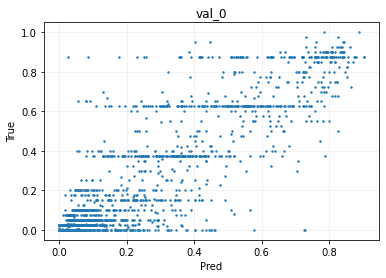

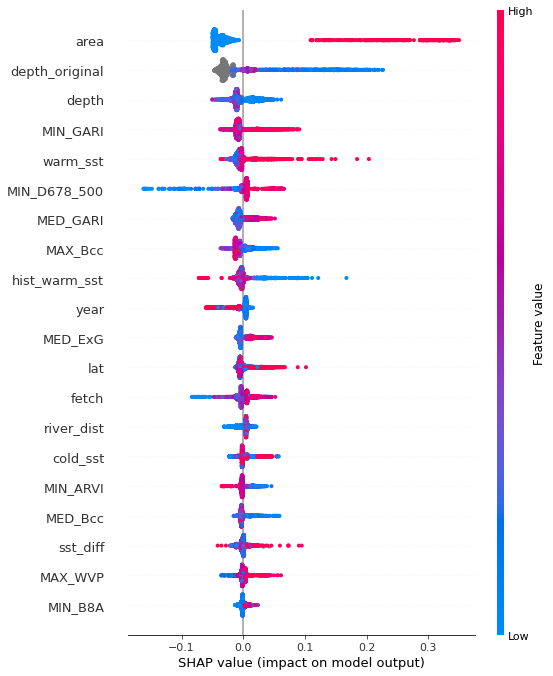

##############################
● CV1
##############################
[500]	valid_0's rmse: 0.134849
[1000]	valid_0's rmse: 0.128211
[1500]	valid_0's rmse: 0.123858
[2000]	valid_0's rmse: 0.120854


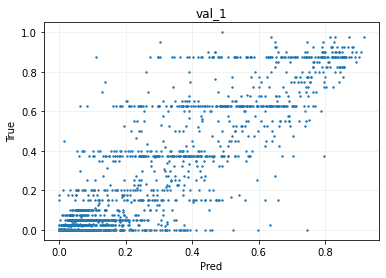

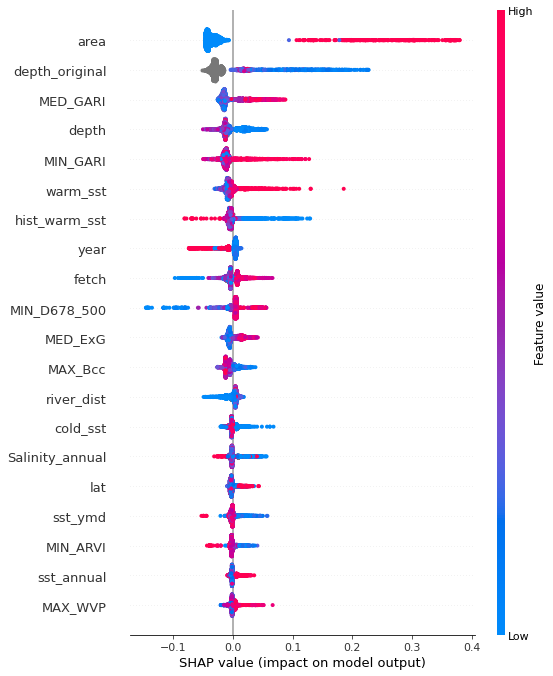

##############################
● CV2
##############################
[500]	valid_0's rmse: 0.133115
[1000]	valid_0's rmse: 0.126432
[1500]	valid_0's rmse: 0.123833
[2000]	valid_0's rmse: 0.12184


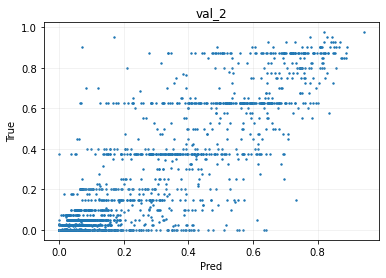

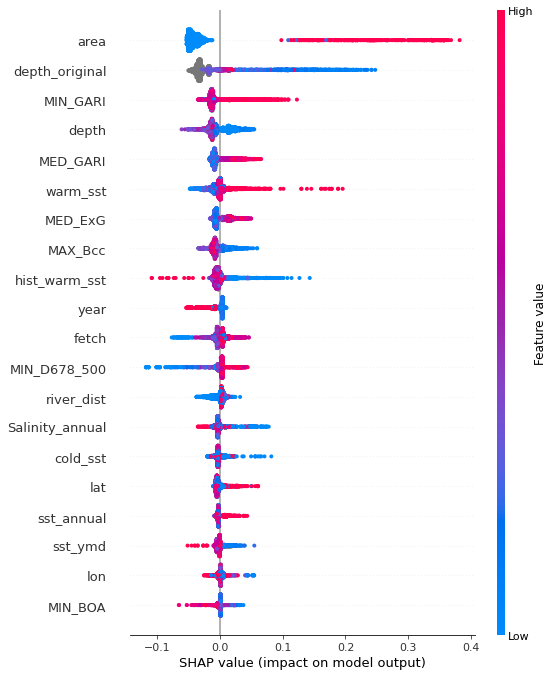

##############################
● CV3
##############################
[500]	valid_0's rmse: 0.133159
[1000]	valid_0's rmse: 0.125017
[1500]	valid_0's rmse: 0.121573
[2000]	valid_0's rmse: 0.119436


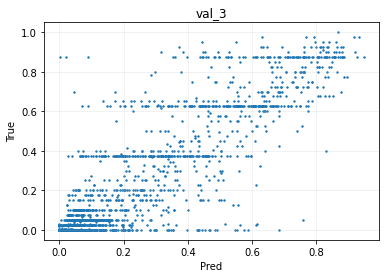

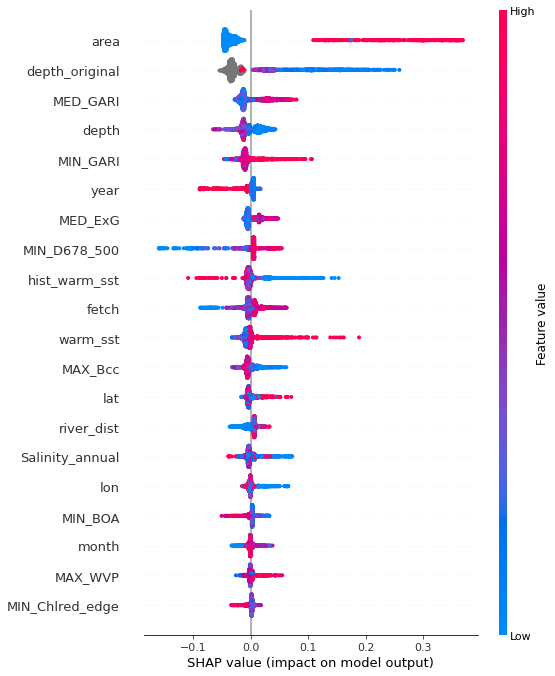

##############################
● CV4
##############################
[500]	valid_0's rmse: 0.13757
[1000]	valid_0's rmse: 0.129539
[1500]	valid_0's rmse: 0.126175
[2000]	valid_0's rmse: 0.12366


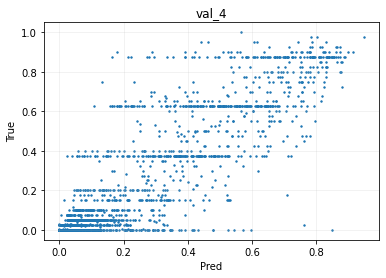

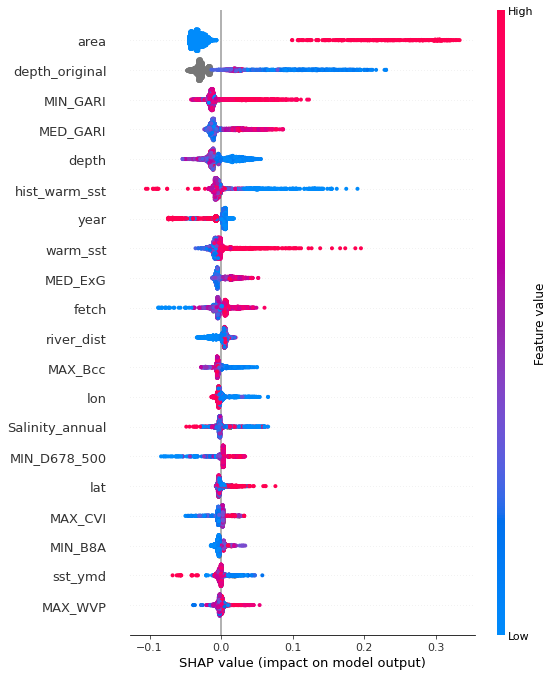

##############################
学習曲線
##############################


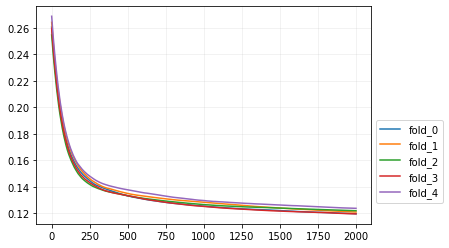

In [ ]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'max_depth': 5,
    'n_estimators': 2000,
    'learning_rate': 0.01,
    # 'num_leaves': 50,
    # 'colsample_bytree': 0.6,
    # 'subsample': 0.5,
    'verbose': -1,
    'n_jobs': -1,
    'seed': 46,
}

results_rmse, fi_df, y_test_pred = my_cross_val_predict(train, test, y_name="cover", params=params, features=features)

CV0: 0.120
CV1: 0.121
CV2: 0.122
CV3: 0.119
CV4: 0.124


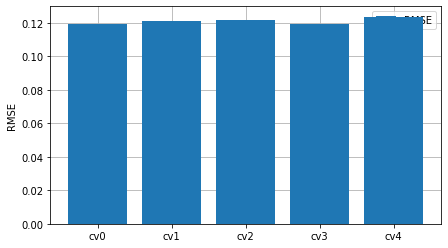

In [ ]:
for i, rmse in enumerate(results_rmse):
    print(f"CV{i}: {rmse:.3f}")
plot_results(results_rmse)

(5, 248)


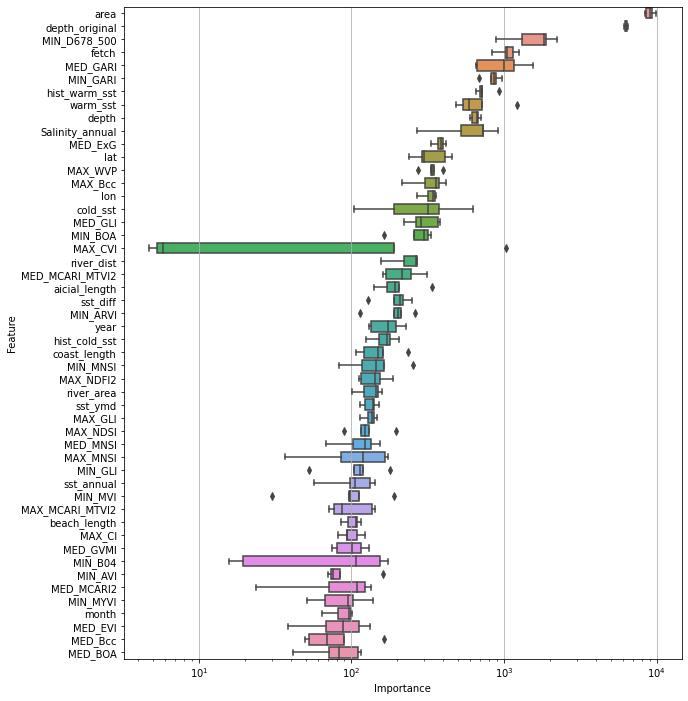

In [ ]:
plot_importance(fi_df, figsize=(10, 12))

# Sub作成

In [ ]:
test_sub = pd.DataFrame(y_test_pred)
test_sub

,0
0,0.207321
1,0.074672
2,0.565292
3,0.037428
4,0.166677
...,...
4034,0.179161
4035,0.033892
4036,0.434595
4037,0.070489


In [ ]:
if SAVE_SUB:
    test_sub.to_csv(SAVE_SUB_DIR / f"{SUB_FILE_NAME}.csv", header=False)